# Expected Exposure simulation with QuantLib and Python

*Copyright (c) 2015 Matthias Groncki*


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

    - Redistributions of source code must retain the above copyright notice,
    this list of conditions and the following disclaimer.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

This disclaimer is taken from the QuantLib license

In [25]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
%matplotlib inline

In [2]:
# Setting evaluation date
today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)

In [3]:
# Setup Marketdata
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
euribor6m = ql.Euribor6M(hyts)

In [4]:
# Setup a dummy portfolio with two Swaps
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 1Y
    
    parameter:
        
        start (ql.Date) : Start Date
        
        maturity (ql.Period) : SwapTenor
        
        nominal (float) : Nominal
        
        fixedRate (float) : rate paid on fixed leg
        
        index (ql.IborIndex) : Index
        
    return: tuple(ql.Swap, list<Dates>) Swap and all fixing dates
    
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

portfolio = [makeSwap(today + ql.Period("2d"),
                      ql.Period("5Y"),
                      1e6,
                      0.03,
                      euribor6m),
             makeSwap(today + ql.Period("2d"),
                      ql.Period("4Y"),
                      5e5,
                      0.03,
                      euribor6m,
                      ql.VanillaSwap.Receiver),
            ]

In [5]:
#%%timeit
# Setup pricing engine and calculate the npv
engine = ql.DiscountingSwapEngine(hyts)
for deal, fixingDates in portfolio:
    deal.setPricingEngine(engine)
    deal.NPV()
    #print(deal.NPV())

In [6]:
# Stochastic Process 

In [7]:
# Assume the model is already calibrated either historical or market implied
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.02))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)

In [8]:
process = model.stateProcess()

In [9]:
# Define evaluation grid
date_grid = [today + ql.Period(i,ql.Weeks) for i in range(0,52*6)]
for deal in portfolio:
    date_grid += deal[1]

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

print(len(time_grid)*1500*2*29e-6)

27.927


In [10]:
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

In [11]:
#%%timeit
# Generate N paths
N = 1500
x = np.zeros((N, len(time_grid)))
y = np.zeros((N, len(time_grid)))
pillars = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
zero_bonds = np.zeros((N, len(time_grid), 12))
for j in range(12):
    zero_bonds[:, 0, j] = model.zerobond(pillars[j],
                                         0,
                                         0)
for n in range(0,N):
    dWs = generator.nextSequence().value()
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        x[n,i] = process.expectation(t0, 
                                     x[n,i-1], 
                                     dt[i-1]) + dWs[i-1] * process.stdDeviation(t0,
                                              x[n,i-1],
                                              dt[i-1])
        y[n,i] = (x[n,i] - process.expectation(0,0,t1)) / process.stdDeviation(0,0,t1)
        for j in range(12):
            zero_bonds[n, i, j] = model.zerobond(t1+pillars[j],
                                                 t1,
                                                 y[n, i])
                                                 

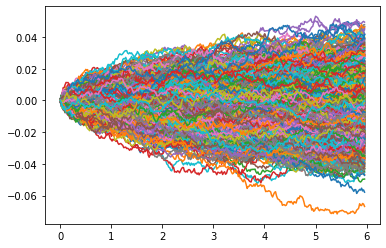

In [12]:
# plot the paths
for i in range(0,N):
    plt.plot(time_grid, x[i,:])

In [13]:
portfolio[0][0].NPV()

2233.4683536877856

In [22]:
portfolio[1][0].NPV()

-884.7496755788889

In [36]:
#%%timeit
#Swap pricing under each scenario
npv_cube = np.zeros((N,len(date_grid), len(portfolio)))
for p in range(0,N):
    for t in range(0, len(date_grid)):
        date = date_grid[t]
        ql.Settings.instance().setEvaluationDate(date)
        ycDates = [date, 
                   date + ql.Period(6, ql.Months)] 
        ycDates += [date + ql.Period(i,ql.Years) for i in range(1,11)]
        yc = ql.DiscountCurve(ycDates, 
                              zero_bonds[p, t, :], 
                              ql.Actual365Fixed())
        yc.enableExtrapolation()
        hyts.linkTo(yc)
        if euribor6m.isValidFixingDate(date):
            fixing = euribor6m.fixing(date)
            euribor6m.addFixing(date, fixing)
        for i in range(len(portfolio)):
            npv_cube[p, t, i] = portfolio[i][0].NPV()
    ql.IndexManager.instance().clearHistories()
ql.Settings.instance().setEvaluationDate(today)
hyts.linkTo(yts)

In [37]:
# Calculate the portfolio npv by netting all NPV
portfolio_npv = np.sum(npv_cube,axis=2)

Text(0.5, 1.0, 'Simulated npv paths')

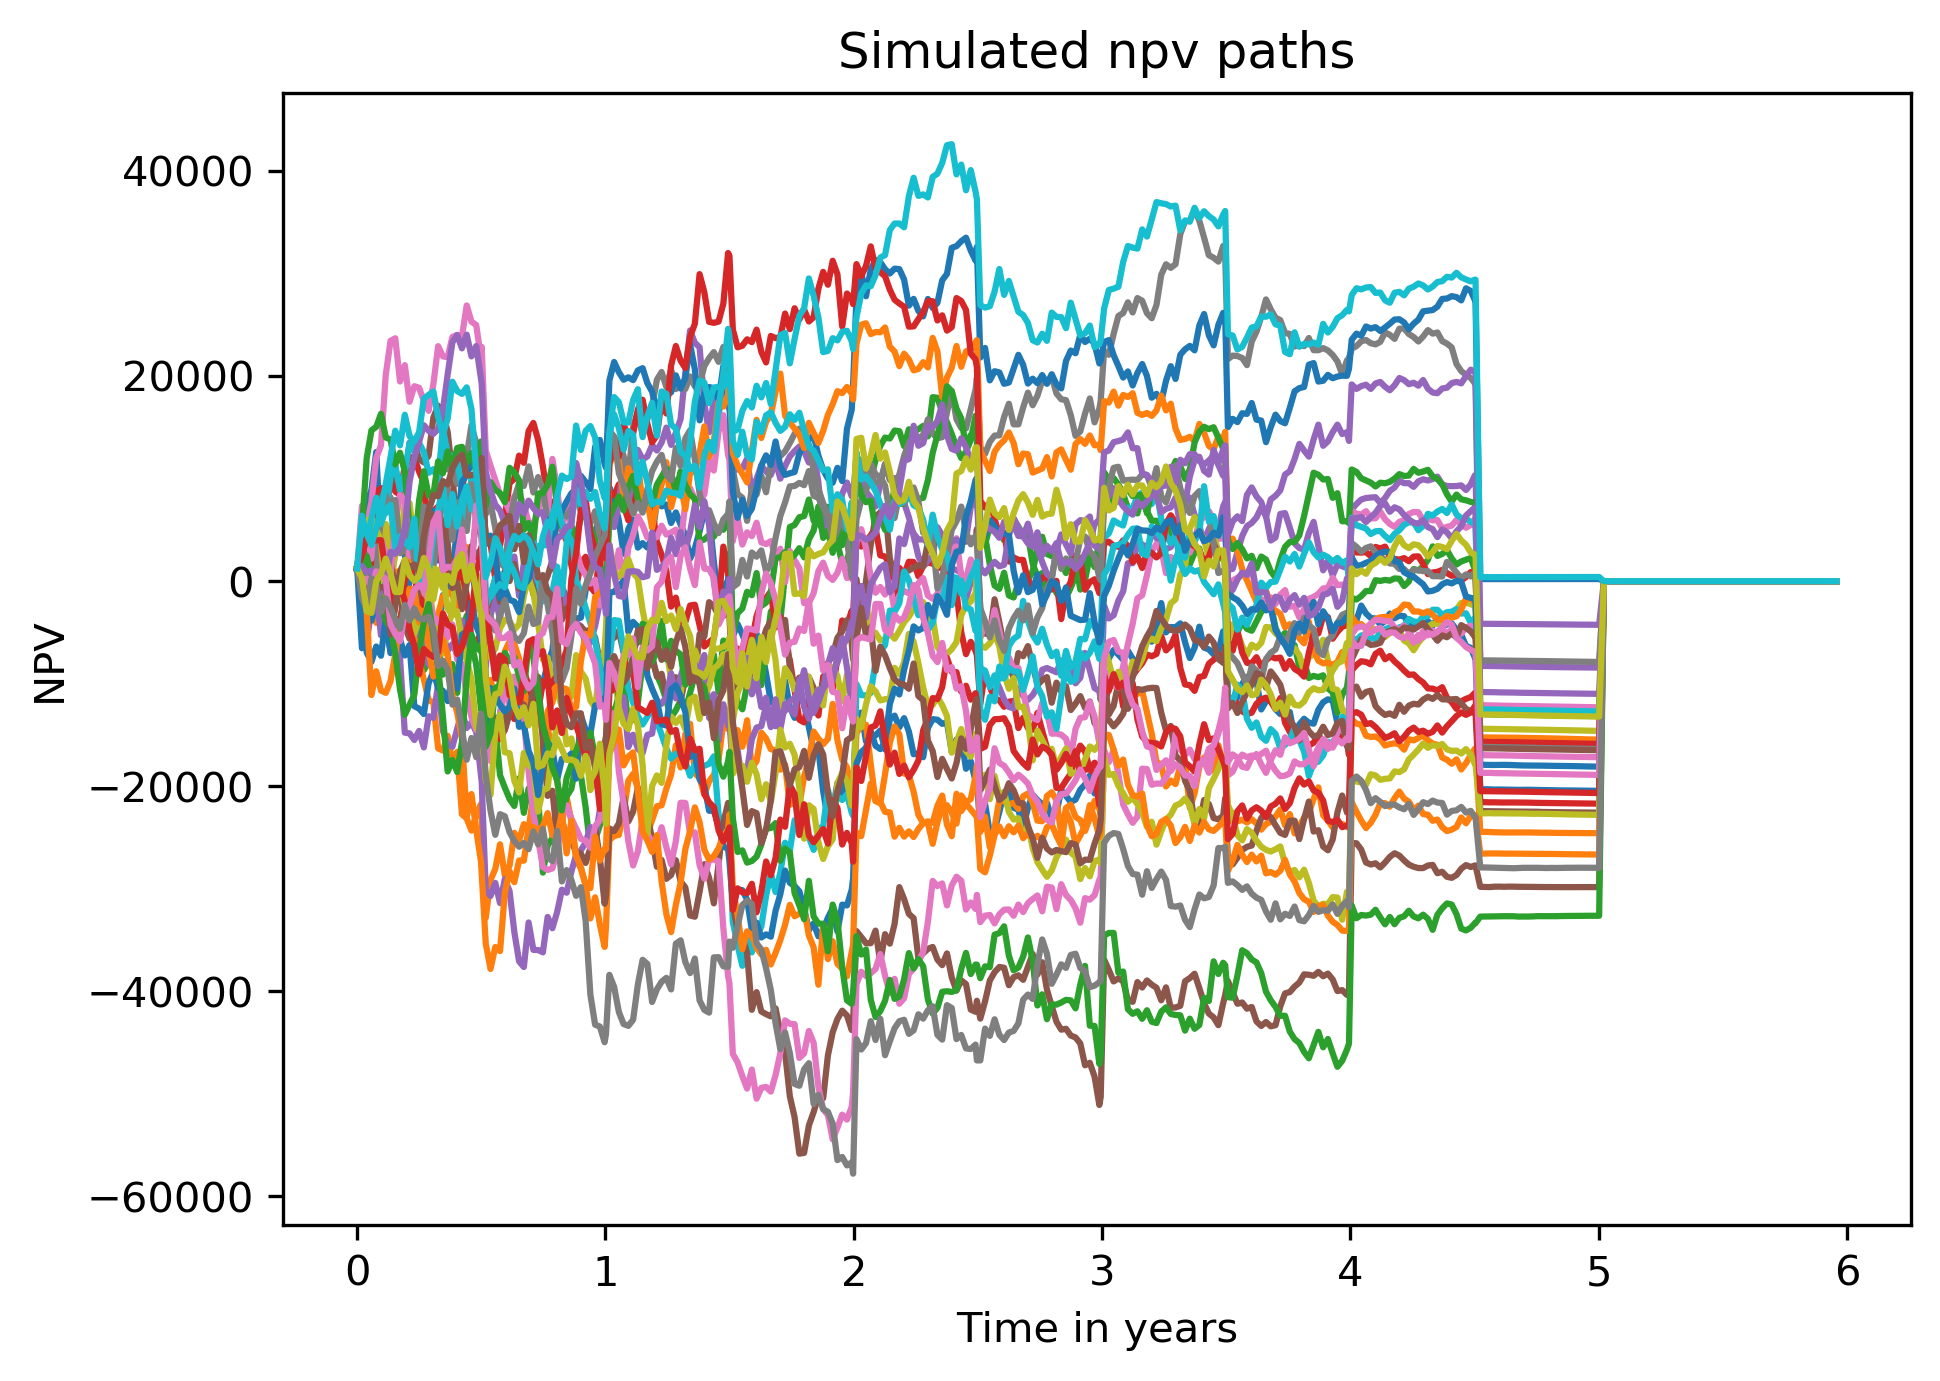

In [38]:
# Plot the first 30 NPV paths
plt.figure(figsize=(7,5), dpi=300)
for i in range(0,30):
    plt.plot(time_grid, portfolio_npv[i,:])
plt.xlabel("Time in years")
plt.ylabel("NPV")
plt.title("Simulated npv paths")

Text(0.5, 1.0, 'Simulated exposure paths')

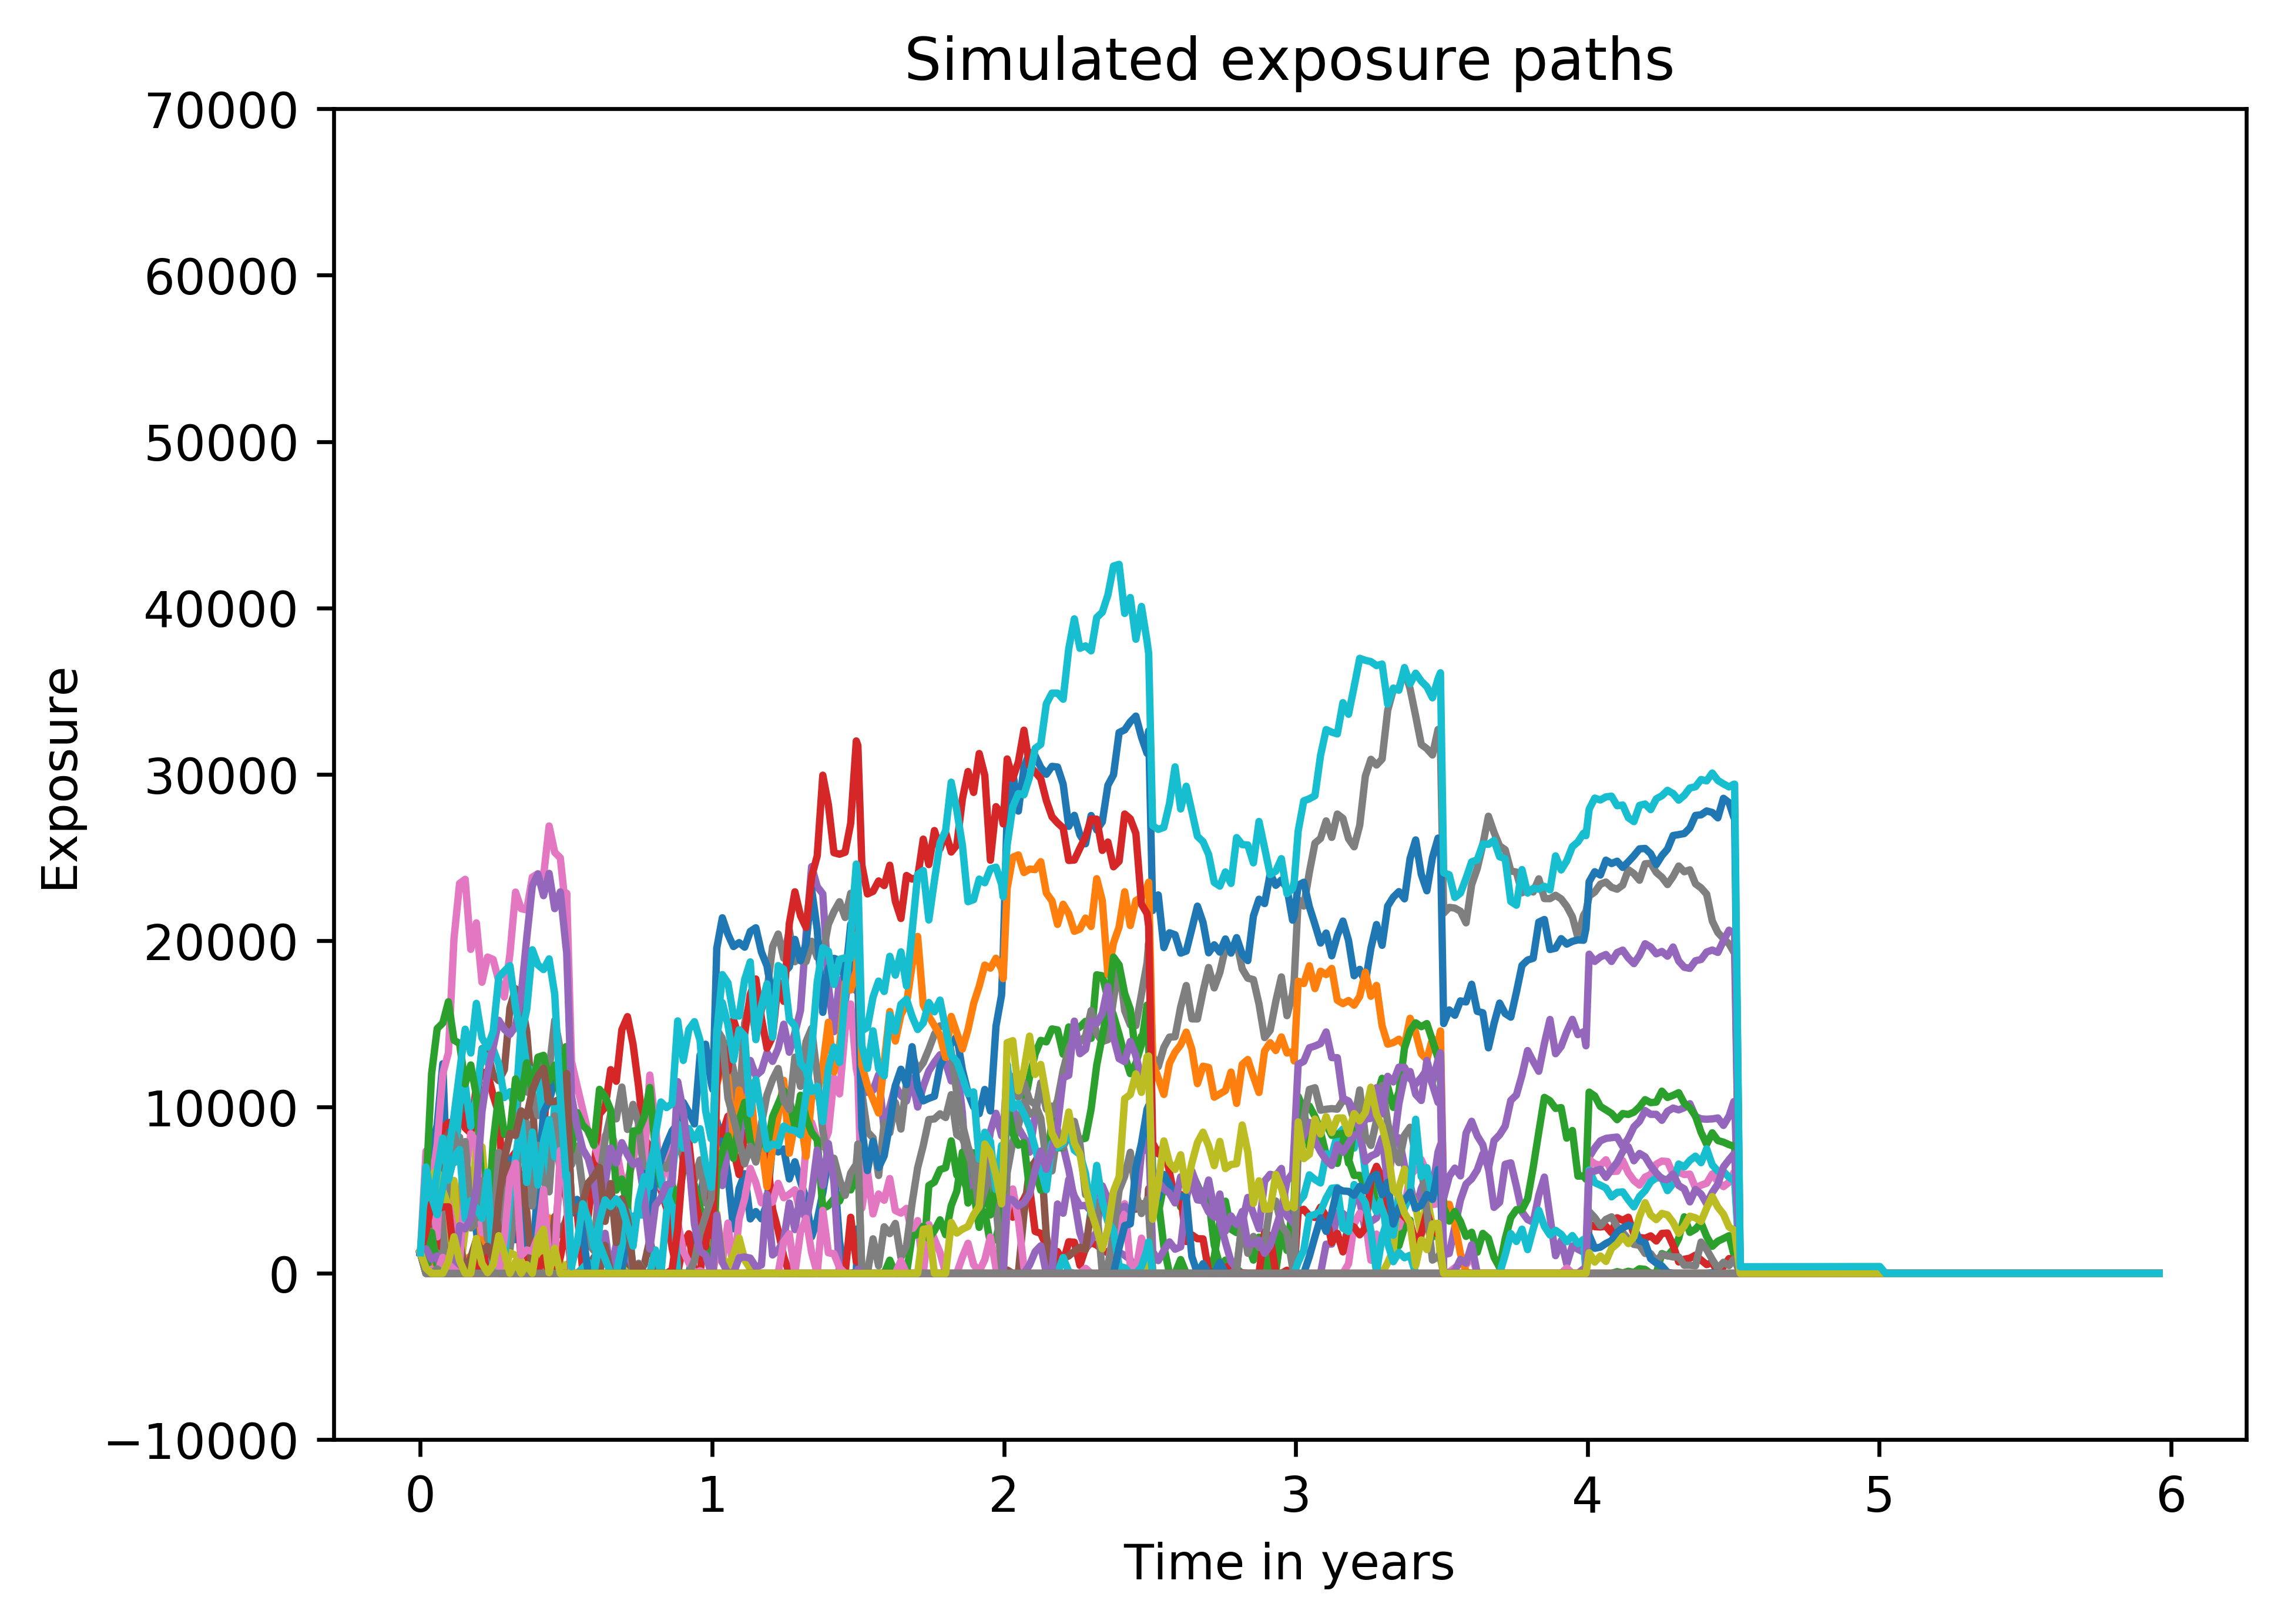

In [39]:
# Calculate the exposure
E = portfolio_npv.copy()
E[E<0]=0
# Plot the first 30 exposure paths
plt.figure(figsize=(7,5), dpi=600)
for i in range(0,30):
    plt.plot(time_grid, E[i,:])
plt.xlabel("Time in years")
plt.ylabel("Exposure")
plt.ylim([-10000,70000])
plt.title("Simulated exposure paths")


In [40]:
# Calculate the expected exposure
E = portfolio_npv.copy()
E[E<0]=0
EE = np.sum(E, axis=0)/N

Text(0.5, 1.0, 'Expected Exposure (netting set)')

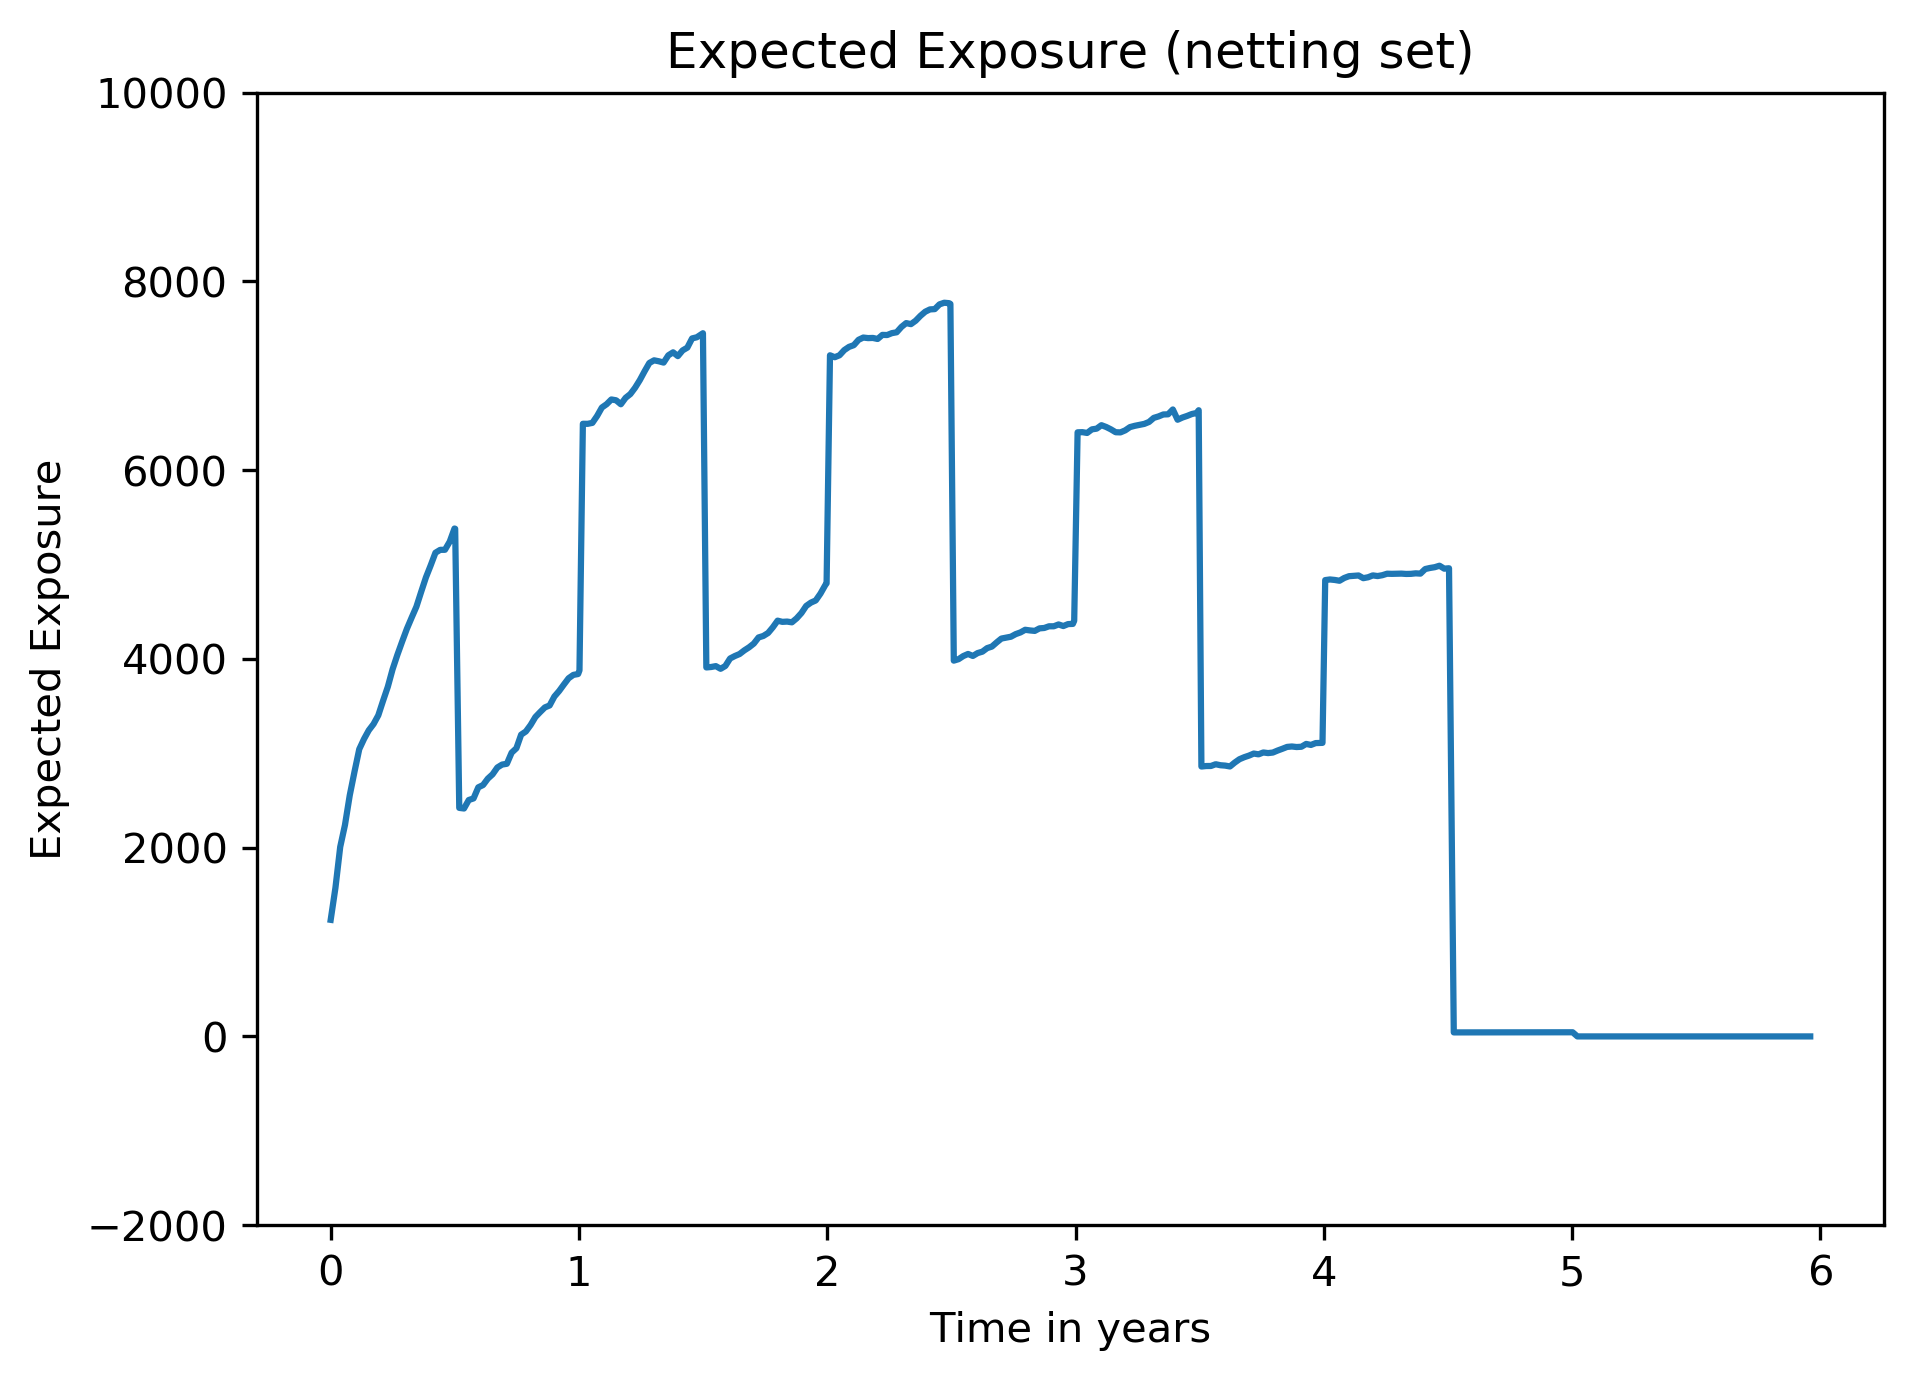

In [41]:
# plot the expected exposure path
plt.figure(figsize=(7,5), dpi=300)
plt.plot(time_grid, EE)
plt.xlabel("Time in years")
plt.ylabel("Expected Exposure")
plt.ylim([-2000,10000])
plt.title("Expected Exposure (netting set)")


In [44]:
x.shape

(1500, 321)

Text(0.5, 1.0, 'PFE (netting set)')

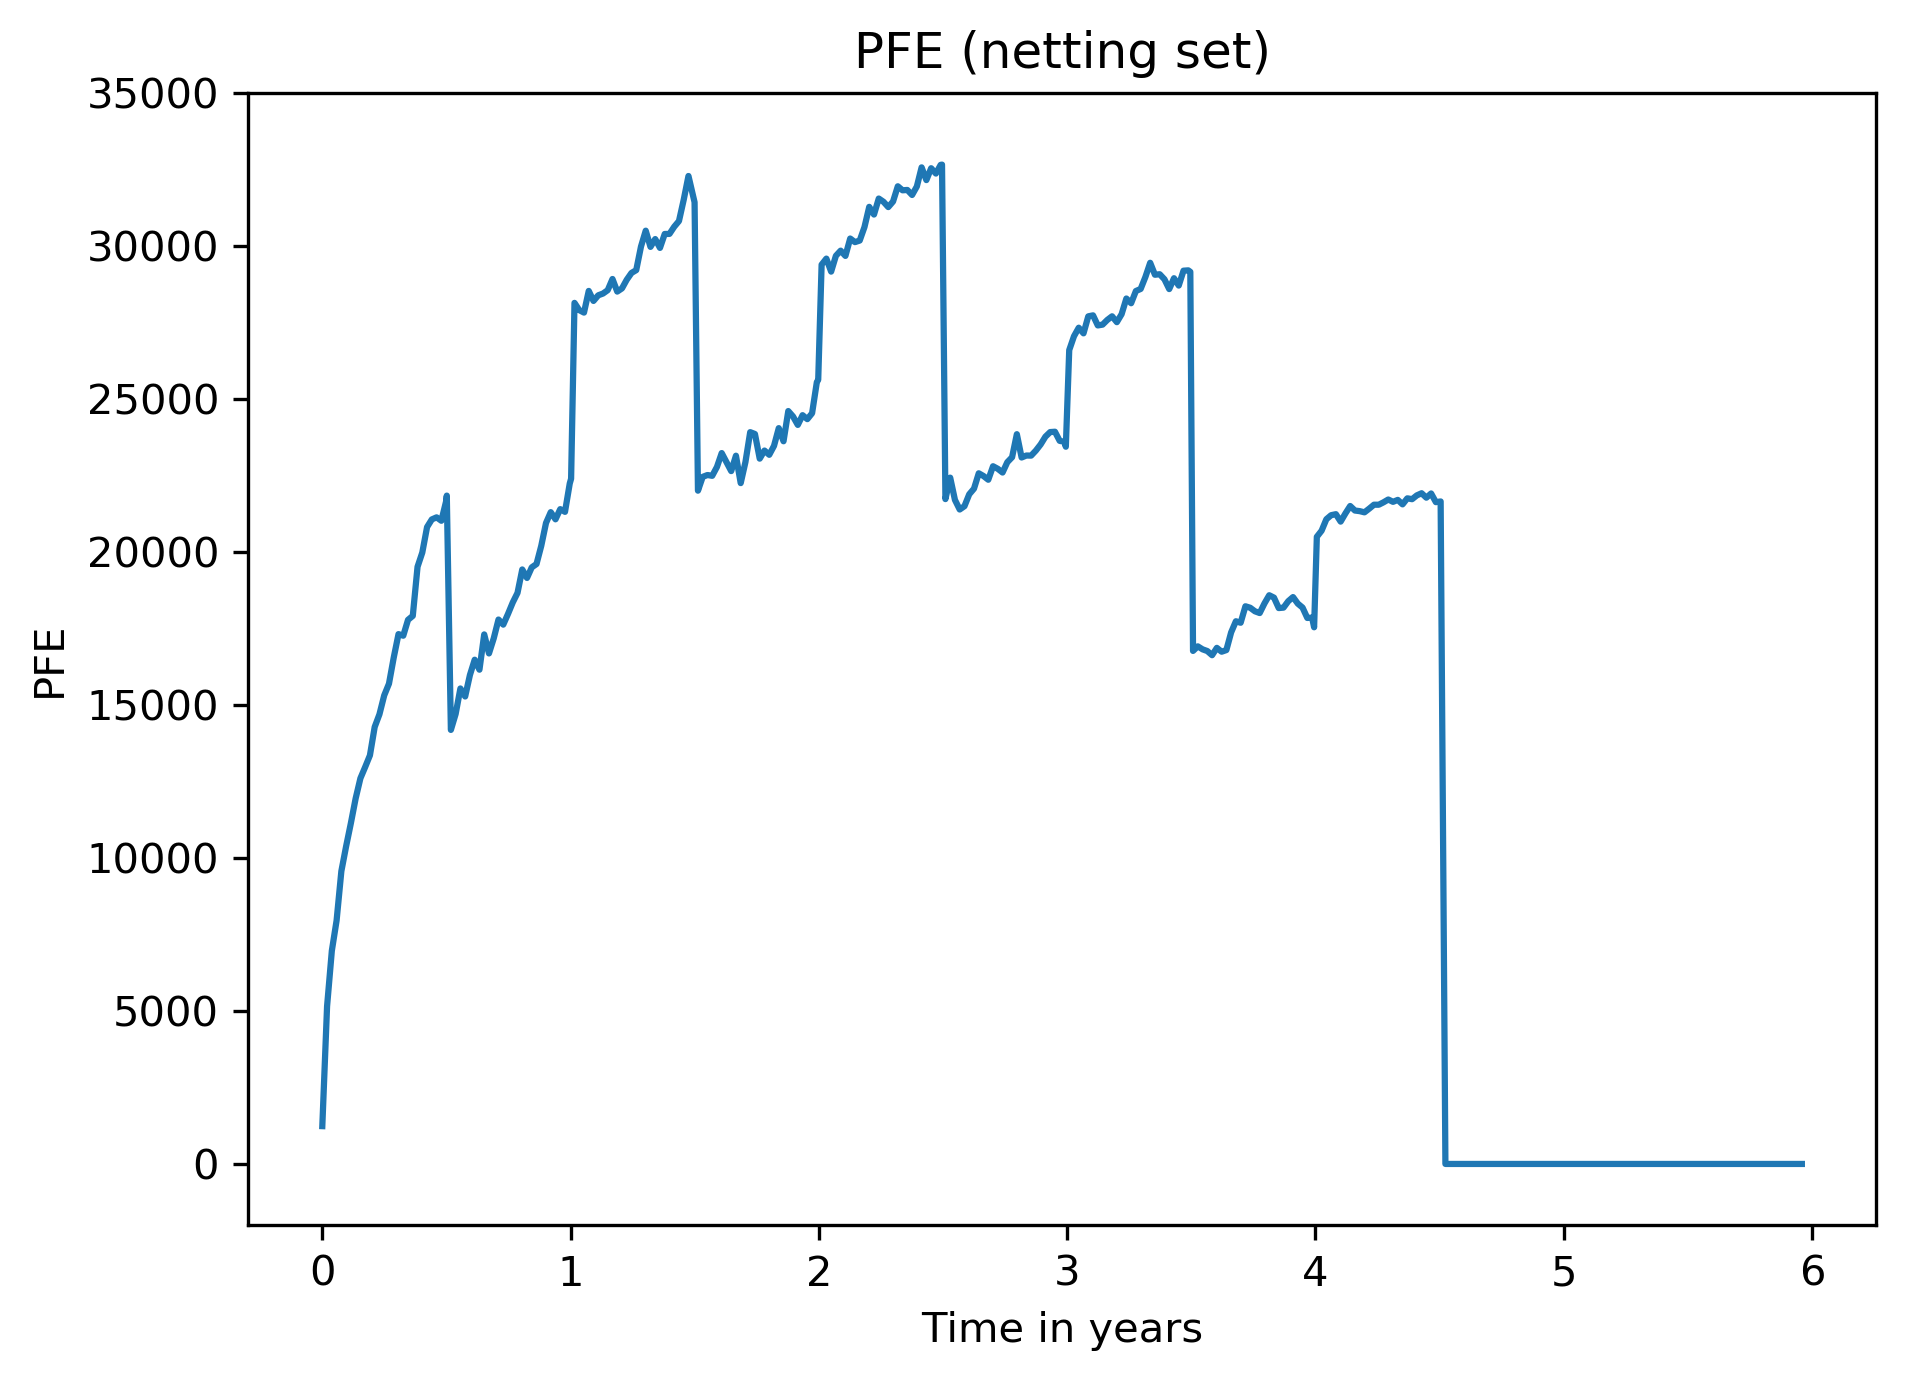

In [48]:
# Calculate the PFE curve (95% quantile)
PFE_curve = np.apply_along_axis(lambda x: np.sort(x)[int(0.95*N)],0, E)

plt.figure(figsize=(7,5), dpi=300)
plt.plot(time_grid,PFE_curve)
plt.xlabel("Time in years")
plt.ylabel("PFE")
plt.ylim([-2000,35000])
plt.title("PFE (netting set)")

In [49]:
# calculate the maximum pfe
MPFE = np.max(PFE_curve)
MPFE

32648.475531747714

In [52]:
# alternative pfe 95% quantile of the maxima of each exposure paths
PFE = np.sort(np.max(E,axis=1))[int(0.95*N)]
PFE

39532.307814450956

In [53]:
import QuantLib as ql
import pandas as pd

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(2, ql.NullCalendar(), 0.015, ql.Actual365Fixed(ql.Actual365Fixed.NoLeap))
)
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(2, ql.NullCalendar(), -0.0065, ql.Actual365Fixed(ql.Actual365Fixed.NoLeap))
)
spot = 1.08417

# dummy parameters
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

heston_helpers = []

data = [
    [1.0953, 4.89],
    [1.111, 4.97],
    [1.1233, 5.12],
    [1.1404, 5.39],
    [1.1533, 5.595],
    [1.1745, 5.923]
]

tenor = ql.Period('6M')
for strike, vol in data:
    helper = ql.HestonModelHelper(tenor, ql.TARGET(), spot,
                                  strike, ql.QuoteHandle(ql.SimpleQuote(vol / 100)), flat_ts, dividend_ts )
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm,  ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

print(f"theta = {theta:.4f}, kappa = {kappa:.4f}, sigma = {sigma:.4f}, rho = {rho:.4f}, v0 = {v0:.4f}")

avg = 0.0

summary = []
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    summary.append((
        data[i][0], opt.marketValue(), 
        opt.modelValue(), 
        100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)

print("Average Abs Error (%%) : %5.3f" % (avg))
df = pd.DataFrame(
    summary,
    columns=["Strikes", "Market value", "Model value", "Relative error (%)"],
    index=['']*len(summary))

theta = 0.0000, kappa = 0.1446, sigma = 0.4418, rho = -0.7200, v0 = 0.0082
Average Abs Error (%) : 9.921
